## I.1. Install

In [ ]:
# # Mount Google Drive (Google Colab ONLY)
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os
# Store the default work path (Google Colab ONLY)
user_path = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks")

# Get the absolute path in the current working directory
# user_path = os.path.dirname(os.path.abspath("NoNeedFilename"))
print(user_path)

/content/drive/MyDrive/Colab\ Notebooks


In [ ]:
# requirements_path = os.path.join(user_path, "requirements.txt")
# print(requirements_path)
# !pip install -r {requirements_path}

## I.2. Libraries Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning
import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam, Nadam, SGD, RMSprop
from sklearn.metrics import confusion_matrix, classification_report
from keras.applications import EfficientNetB3, EfficientNetB5, EfficientNetV2B1, EfficientNetV2B3

## I.4. Image Processing

### I.4.2. Set Image Folder Path

In [ ]:
# Google Colab ONLY
train_dir = r"/content/drive/MyDrive/Colab Notebooks/IMAGE_SPLIT/train"
val_dir = r"/content/drive/MyDrive/Colab Notebooks/IMAGE_SPLIT/val"
test_dir = r"/content/drive/MyDrive/Colab Notebooks/IMAGE_SPLIT/test"

# train_dir = r"C:\WORKSPACES\DATA\ML_DL\IMAGE_SPLIT\train"
# val_dir = r"C:\WORKSPACES\DATA\ML_DL\IMAGE_SPLIT\val"
# test_dir = r"C:\WORKSPACES\DATA\ML_DL\IMAGE_SPLIT\test"

### I.4.3. Data augmentation techniques

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = [0.9, 1.25],
    brightness_range = [0.5, 1.5],
    horizontal_flip = True,
    vertical_flip = True
)

val_datagen = ImageDataGenerator(
    rescale = 1./255)

test_datagen = ImageDataGenerator(
    rescale = 1./255)

### I.4.4. Setup data generators

In [ ]:
# Variables
batch_size = 32
height = 240
width = 240
image_shape = (height, width) # images of size 240x240 px with 3 color channels RGB automatically


train_generator = train_datagen.flow_from_directory(
    train_dir,
    class_mode = "categorical",
    target_size = image_shape,
    batch_size = batch_size
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    class_mode = "categorical",
    target_size = image_shape,
    batch_size = batch_size
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    class_mode = "categorical",
    target_size = image_shape,
    batch_size = batch_size,
    shuffle = False
)

Found 4200 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


## II.1. Define all the variables

In [ ]:
# Model to use
model_name = "EfficientNetV2B1"
ModelNameFunc = globals()[model_name]

# Top Architecture new CNN model
l1_neurons = 64 # Number of neurons on layer 1 (deeper)
l1_activation = "relu"
dropout = 0.5 # 0.2 - 0.5
l2_neurons = 32 # Number of neurons on layer 2
l2_activation = "relu"
output_neurons = 3 # this layer will have 3 neurons or units fully connected. In line with our 3 classes.
output_activation = "softmax"

# model.compile
compile_optimizer = "Adam" # Test : Nadam,
compile_loss = "categorical_crossentropy" # More than 2 classes, so categorical
compile_metrics = ["accuracy", keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall"), keras.metrics.AUC(name="auc")]

# Train model.fit
epochs = 30
verbose = 1

# Fine tuning model.compile
ft_compile_optimizer = Adam(learning_rate = 1e-5)
# Optimizer : Very low learning rate
ft_compile_loss = "categorical_crossentropy" # More than 2 classes, so categorical
ft_compile_metrics =  ["accuracy", keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall"), keras.metrics.AUC(name="auc")]

# Fine tuning model.fit
ft_epochs = 15
ft_verbose = 1

# File Path .h5
fileh5_path = os.path.join(user_path, f"{model_name}_H5_Model", f"{model_name}_TRAIN_ManualSave.h5")
ft_fileh5_path = os.path.join(user_path, f"{model_name}H5_Model", f"{model_name}_FT_ManualSave.h5")

## II.2. Define optimizations

### II.2.1. Train optimizations

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Define the early stopping
early_stopping = EarlyStopping(
    monitor = "val_loss",        # Metric to monitor
    patience = 5,                # Number of epochs with no improvement (around 10% of nb of epochs)
    verbose = 1,                 # Verbosity mode (0, 1, or 2)
    restore_best_weights = True  # Whether to restore model weights to the best epoch
)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor = "val_loss",  # Metric to monitor
    factor = 0.2,          # Factor by which to reduce the learning rate
    patience = 5,          # Number of epochs with no improvement
    verbose = 1,           # Verbosity mode (0, 1, or 2)
    min_lr = 1e-6          # Minimum learning rate
)

# Define the model checkpoint callback
checkpoint = ModelCheckpoint(
    # filepath = os.path.join(user_path, "ft_checkpoint"), # to use if don't wanna save to a file .h5 or .keras
    filepath = os.path.join(user_path, f"{model_name}_H5_Model", f"{model_name}_TRAIN_MCPBest.h5"),    # Filepath to save the checkpoint
    monitor = "val_loss",       # Metric to monitor
    save_freq = "epoch",        # Default = epoch
    save_weights_only = False,  # Default = False
    save_best_only = True,      # Save only if the monitored metric improves
    mode = "min",               # "min" if monitoring loss, "max" if monitoring accuracy
    verbose = 1                 # Verbosity mode (0, 1, or 2)
)

# Define TensorBoard Logs
log_dir = os.path.join(user_path, f"{model_name}_LOGS_TRAIN")
tensorboard = TensorBoard(log_dir)

# Include it in the callbacks list
callbacks_list = [early_stopping, lr_scheduler, checkpoint, tensorboard]

### II.2.2. Fine Tune Optimization

In [ ]:
# Define the early stopping
ft_early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 3,
    verbose = 1,                 # Verbosity mode (0, 1, or 2)
    restore_best_weights = True  # Whether to restore model weights to the best epoch
)

# Define the learning rate scheduler
ft_lr_scheduler = ReduceLROnPlateau(
    monitor = "val_loss",  # Metric to monitor
    factor = 0.2,          # Factor by which to reduce the learning rate
    patience = 3,          # Number of epochs with no improvement
    verbose = 1,           # Verbosity mode (0, 1, or 2)
    min_lr = 1e-6          # Minimum learning rate
)

# Define the model checkpoint callback
ft_checkpoint = ModelCheckpoint(
    # filepath = os.path.join(user_path, "ft_checkpoint"), # to use if don't wanna save to a file .h5 or .keras
    filepath = os.path.join(user_path, f"{model_name}_H5_Model", f"{model_name}_FT_MCPBest.h5"),    # Filepath to save the checkpoint
    monitor = "val_loss",       # Metric to monitor
    save_freq = "epoch",        # Default = epoch
    save_weights_only = False,  # Default = False
    save_best_only = True,      # Save only if the monitored metric improves
    mode = "min",               # "min" if monitoring loss, "max" if monitoring accuracy
    verbose = 1                 # Verbosity mode (0, 1, or 2)
)

# Define TensorBoard Logs
ft_log_dir = os.path.join(user_path, f"{model_name}_LOGS_FT")
ft_tensorboard = TensorBoard(ft_log_dir)

# Include it in the callbacks list
ft_callbacks_list = [ft_early_stopping, ft_lr_scheduler, ft_checkpoint, ft_tensorboard]

## II.3. Pre trained model

### II.3.1. Instantiate a base model with pre-trained model and weights

In [ ]:
# First instantiate a base model with pre-trained weights
base_model = ModelNameFunc(
    include_top = False,
    weights = "imagenet",
    include_preprocessing = False, # ONLY for V2 model
    input_shape = (height, width, output_neurons)
)

28456008/28456008 [==============================] - 0s 0us/step


In [ ]:
display(base_model.input)

<KerasTensor: shape=(None, 240, 240, 3) dtype=float32 (created by layer 'input_1')>

### II.3.2. Define the new architecture on top

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(l1_neurons, activation = l1_activation)(x)
x = Dropout(dropout)(x)
x = Dense(l2_neurons, activation = l2_activation)(x)
x = BatchNormalization()(x)

predictions = Dense(output_neurons, activation = output_activation)(x)

model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
print(model.input_shape)

(None, 240, 240, 3)


### II.3.4. Compile the model
model.compile in Keras will configure the model for training

In [ ]:
model.compile(
    optimizer = compile_optimizer,
    loss = compile_loss,
    metrics = compile_metrics
)

### II.3.5. Pre Train the model
It's called "history" because it essentially keeps a historical record of various metrics and data related to how the model performed during training.

In [ ]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = train_generator.samples // batch_size + 1,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size + 1,
    epochs = epochs,
    verbose = verbose,
    callbacks = callbacks_list
)

# Save the model
model.save(fileh5_path)

Epoch 1/30
132/132 [==============================] - ETA: 0s - loss: 0.3338 - accuracy: 0.8805 - precision: 0.9079 - recall: 0.8540 - auc: 0.9709
Epoch 1: val_loss improved from inf to 0.27373, saving model to /content/drive/MyDrive/Colab\ Notebooks/EfficientNetV2B1_H5_Model/EfficientNetV2B1_TRAIN_MCPBest.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 1283s 9s/step - loss: 0.3338 - accuracy: 0.8805 - precision: 0.9079 - recall: 0.8540 - auc: 0.9709 - val_loss: 0.2737 - val_accuracy: 0.9192 - val_precision: 0.9227 - val_recall: 0.9150 - val_auc: 0.9819 - lr: 0.0010
Epoch 2/30
132/132 [==============================] - ETA: 0s - loss: 0.1919 - accuracy: 0.9352 - precision: 0.9470 - recall: 0.9236 - auc: 0.9892
Epoch 2: val_loss improved from 0.27373 to 0.12550, saving model to /content/drive/MyDrive/Colab\ Notebooks/EfficientNetV2B1_H5_Model/EfficientNetV2B1_TRAIN_MCPBest.h5
132/132 [==============================] - 119s 905ms/step - loss: 0.1919 - accuracy: 0.9352 - precision: 0.9470 - recall: 0.9236 - auc: 0.9892 - val_loss: 0.1255 - val_accuracy: 0.9542 - val_precision: 0.9550 - val_recall: 0.9542 - val_auc: 0.9950 - lr: 0.0010
Epoch 3/30
132/132 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.9393 - precision: 0.9447 - recall: 0.9312 - auc: 0.9894
Epoch 3: val_los

### II.3.7. Evaluate Pre trained model

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on Test Data")
results = model.evaluate(test_generator, batch_size = batch_size)
# print("Test loss, Test accuracy : ", results)

Evaluate on Test Data
19/19 [==============================] - 164s 9s/step - loss: 0.0659 - accuracy: 0.9800 - precision: 0.9833 - recall: 0.9800 - auc: 0.9989


### II.3.8. Plot the Accuracy and the loss graphs

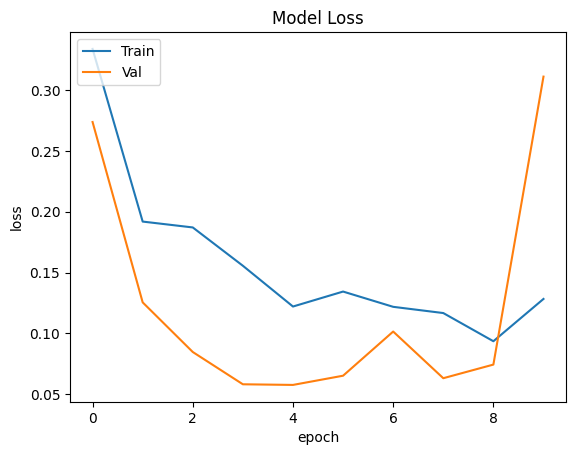

In [ ]:
# Plot the Loss graph
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["Train", "Val"], loc = "upper left")
plt.show()

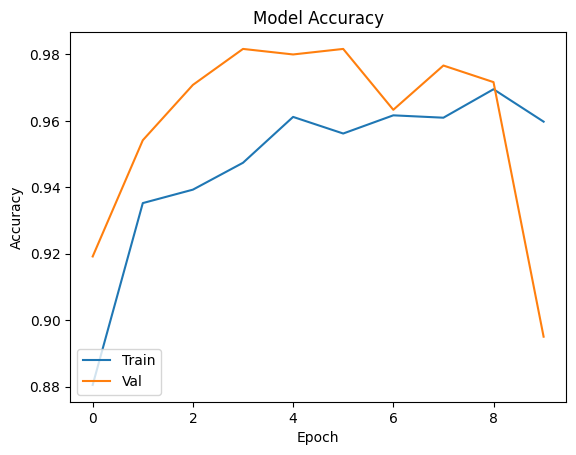

In [ ]:
# Plot the Accuracy graph
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc = "lower left")
plt.show()

### II.3.8. Confusion Matrix

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(test_generator, steps = test_generator.samples // batch_size + 1)
# Convert predictions classes from one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations from one hot vectors
# Y_true = np.argmax(test_generator.classes, axis = 1)
# OR
Y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix")
print(cm)

# Retrieve class names (label)
names_from_dir = sorted(os.listdir(val_dir))
dict(enumerate(names_from_dir))
#OR
class_names = list(val_generator.class_indices.keys())
# Check if the both are similar
print(names_from_dir == class_names)

# Print the classification report
print("Classification Report")
print(classification_report(Y_true, Y_pred_classes, target_names = class_names))


19/19 [==============================] - 7s 249ms/step
Confusion Matrix
[[199   1   0]
 [  4 195   1]
 [  4   2 194]]
True
Classification Report
              precision    recall  f1-score   support

         Bee       0.96      0.99      0.98       200
   Butterfly       0.98      0.97      0.98       200
     Ladybug       0.99      0.97      0.98       200

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



In [ ]:
def plot_confusion_matrix(
    cm,
    classes,
    normalize = False,
    title = "Confusion matrix",
    cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis =1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Normalized confusion matrix
[[0.995 0.005 0.   ]
 [0.02  0.975 0.005]
 [0.02  0.01  0.97 ]]


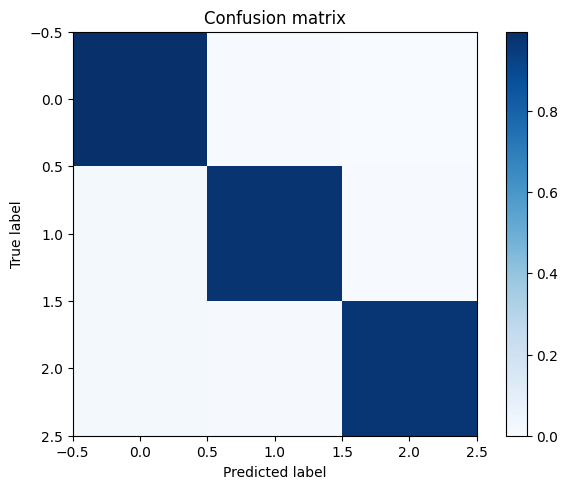

In [ ]:
plot_confusion_matrix(
    cm,
    class_names,
    normalize = True,
    title = "Confusion matrix",
    cmap = plt.cm.Blues
    )

## II.4. Fine Tuning
This requires unfreezing the base model and then recompiling the model (necessary for the changes to take effect), and then resuming training.

### II.4.1. Unfreeze the base model

In [ ]:
# Unfreeze the base model
base_model.trainable = True

### II.4.2. Re compile the model with a very low learning rate

In [ ]:
# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(
    optimizer = ft_compile_optimizer,
    loss = ft_compile_loss,
    metrics = ft_compile_metrics
)

### II.4.3. Retraining the model

In [ ]:
# Resume training
ft_history = model.fit(
    x = train_generator,
    steps_per_epoch = train_generator.samples // batch_size + 1,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size + 1,
    epochs = ft_epochs,
    verbose = ft_verbose,
    callbacks = ft_callbacks_list
)

# Save the Fine tuned model
model.save(ft_fileh5_path)

Epoch 1/15
132/132 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9702 - precision: 0.9731 - recall: 0.9657 - auc: 0.9965
Epoch 1: val_loss improved from inf to 0.04583, saving model to /content/drive/MyDrive/Colab\ Notebooks/EfficientNetV2B1_H5_Model/EfficientNetV2B1_FT_MCPBest.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 181s 932ms/step - loss: 0.1018 - accuracy: 0.9702 - precision: 0.9731 - recall: 0.9657 - auc: 0.9965 - val_loss: 0.0458 - val_accuracy: 0.9875 - val_precision: 0.9883 - val_recall: 0.9867 - val_auc: 0.9994 - lr: 1.0000e-05
Epoch 2/15
132/132 [==============================] - ETA: 0s - loss: 0.0910 - accuracy: 0.9743 - precision: 0.9756 - recall: 0.9710 - auc: 0.9973
Epoch 2: val_loss improved from 0.04583 to 0.04188, saving model to /content/drive/MyDrive/Colab\ Notebooks/EfficientNetV2B1_H5_Model/EfficientNetV2B1_FT_MCPBest.h5
132/132 [==============================] - 122s 924ms/step - loss: 0.0910 - accuracy: 0.9743 - precision: 0.9756 - recall: 0.9710 - auc: 0.9973 - val_loss: 0.0419 - val_accuracy: 0.9900 - val_precision: 0.9900 - val_recall: 0.9892 - val_auc: 0.9994 - lr: 1.0000e-05
Epoch 3/15
132/132 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.9729 - precision: 0.9756 - recall: 0.9710 - auc: 0.9968
Epoch 3: 

### II.4.4. Evaluation Fine Tune Model

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on Test Data")
results = model.evaluate(test_generator, batch_size = batch_size)
print("Test loss, Test accuracy : ", results)

Evaluate on Test Data
19/19 [==============================] - 5s 264ms/step - loss: 0.0363 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9997
Test loss, Test accuracy :  [0.03625289350748062, 0.9883333444595337, 0.9883333444595337, 0.9883333444595337, 0.9996610879898071]


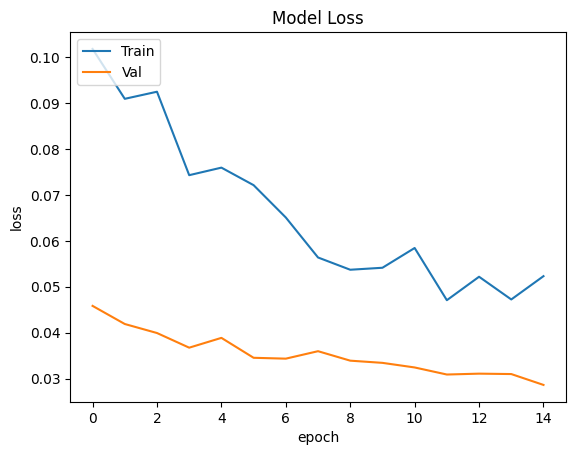

In [ ]:
# Plot the Loss graph
plt.plot(ft_history.history["loss"])
plt.plot(ft_history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["Train", "Val"], loc = "upper left")
plt.show()

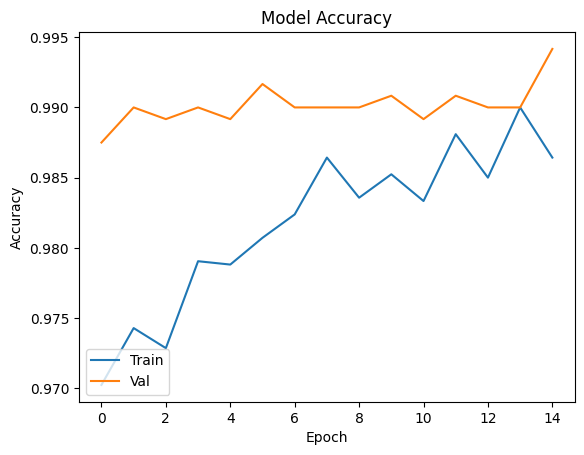

In [ ]:
# Plot the Accuracy graph
plt.plot(ft_history.history["accuracy"])
plt.plot(ft_history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc = "lower left")
plt.show()

### II.4.5. Confusion Matrix Fine Tuned Model

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(test_generator, steps = test_generator.samples // batch_size + 1)
# Convert predictions classes from one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations from one hot vectors
# Y_true = np.argmax(test_generator.classes, axis = 1)
# OR
Y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix")
print(cm)

# Retrieve class names (label)
names_from_dir = sorted(os.listdir(val_dir))
dict(enumerate(names_from_dir))
#OR
class_names = list(val_generator.class_indices.keys())
# Check if the both are similar
print(names_from_dir == class_names)

# Print the classification report
print("Classification Report")
print(classification_report(Y_true, Y_pred_classes, target_names = class_names))

# classification_report = classification_report(test_generator.classes, Y_pred_classes, target_names = class_names)
# print(classification_report)

19/19 [==============================] - 7s 240ms/step
Confusion Matrix
[[198   2   0]
 [  2 198   0]
 [  1   2 197]]
True
Classification Report
              precision    recall  f1-score   support

         Bee       0.99      0.99      0.99       200
   Butterfly       0.98      0.99      0.99       200
     Ladybug       1.00      0.98      0.99       200

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



Normalized confusion matrix
[[0.99  0.01  0.   ]
 [0.01  0.99  0.   ]
 [0.005 0.01  0.985]]


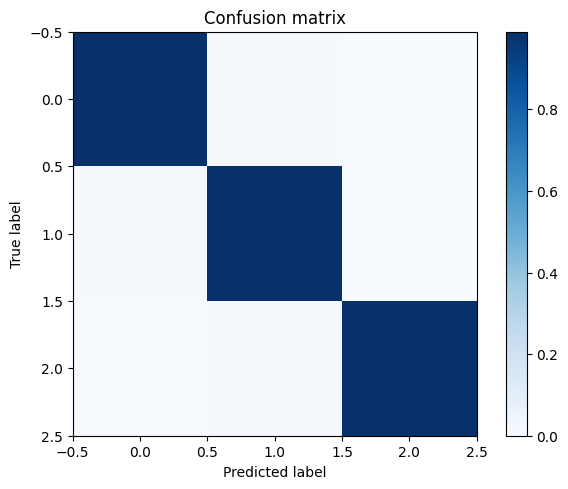

In [ ]:
plot_confusion_matrix(cm,
                      class_names,
                      normalize = True,
                      title = "Confusion matrix",
                      cmap = plt.cm.Blues
                      )

### II.4.6. Some metrics of Fine Tune Model


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcul de la précision
precision = precision_score(test_generator.classes, Y_pred_classes, average='macro') # average macro, calcul individuel par classe attribut le même poids à chaque classe
# Calcul du recall
recall = recall_score(test_generator.classes, Y_pred_classes, average='macro')

# Calcul du F1 score
f1 = f1_score(test_generator.classes, Y_pred_classes, average='macro')

# Affichage des résultats
print("Précision :", precision)
print("Recall :", recall)
print("F1 score :", f1)

Précision : 0.9884242155558839
Recall : 0.9883333333333333
F1 score : 0.9883497079575082


In [ ]:
# Calcul de la précision
precision = precision_score(test_generator.classes, Y_pred_classes, average='weighted') # average Weighted, calcul individuel par classe pour pondéré en fonction du poids de chaque classe

# Calcul du recall
recall = recall_score(test_generator.classes, Y_pred_classes, average='weighted')

# Calcul du F1 score
f1 = f1_score(test_generator.classes, Y_pred_classes, average='weighted')

# Affichage des résultats
print("Précision :", precision)
print("Recall :", recall)
print("F1 score :", f1)

Précision : 0.9884242155558839
Recall : 0.9883333333333333
F1 score : 0.9883497079575083


In [ ]:
precision = precision_score(test_generator.classes, Y_pred_classes, average='micro') # average micro, Calcule la précision globale en agrégeant les vrais positifs, faux positifs et faux négatifs sur toutes les classes

# Calcul du recall
recall = recall_score(test_generator.classes, Y_pred_classes, average='micro')

# Calcul du F1 score
f1 = f1_score(test_generator.classes, Y_pred_classes, average='micro')

# Affichage des résultats
print("Précision :", precision)
print("Recall :", recall)
print("F1 score :", f1)

Précision : 0.9883333333333333
Recall : 0.9883333333333333
F1 score : 0.9883333333333333


# III. READ LOGS

In [ ]:
%load_ext tensorboard
%tensorboard --logdir log_dir

<IPython.core.display.Javascript object>

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ft_log_dir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-09-26 16:06:11.198247: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.